### Home work 4

### Hamiltonian Monte Carlo  and Metropolis-Hastings Algorithm


In [142]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Intro -  How to calculate gradients from distribution ?

One can consider the case of multivariate normal distribution, where k is dimensionality of space, and the density looks like as follow:

$$ p(x) = \frac{1}{(2\pi)^{k/2} \sqrt{det \Sigma}}  exp[-\frac{1}{2}(x - \mu)^{T}\Sigma^{-1}(x - \mu)] $$

Let, k = 2, $\mu$ = [0., 0.] and $\Sigma$ is identity matrix , then:

$$ \log p(x) \sim  x^{T}x $$

Then , we now , that $$ \frac{\partial{x^{T}x}}{\partial {x}} = 2x$$

we don't need calculate it by hands, python can take the gradient in a certain point

In [143]:
log_p = lambda x: x.T@x
# point, when we want to calculate the gradient
x = torch.nn.Parameter(torch.tensor([2.,3.]),requires_grad=True)

log_p( x.clone() ).backward()
print("expected torch.tensor([4.,6.]), and get {}".format(x.grad))

expected torch.tensor([4.,6.]), and get tensor([4., 6.])


### 1 Target Distribution

Right now we create base class for any distribution, which we want to sample from

In [144]:
class Distribution:
    
    """
    Abstract class for unnormalized density
    
    """
    
    def log_density(self, x):
        
        """
        x : torch.tensor of shape BxD
        return : torch.tensor of shape B
        
        """
        raise NotImplementedError
    
    def grad_log_density(self, x):
        
        """
        x : torch.tensor of shape BxD
        return : torch.tensor of shape BxD
        
        Note:
        We make sum before backward because:
        
        RuntimeError: grad can be implicitly created only for scalar outputs
        
        """
        
        x = x.clone().requires_grad_()
        log_density = self.log_density(x) # torch.tensor of shape Bx1
        log_density.sum().backward()
        
        return x.grad # torch.tenosr of shape B x D
        

In this notebook we consider four distributions on which we test vanilla HMC  anf MH - algrorithm
- 1. Typical Normal Isotropic distribution:
$$ \pi(x) = \mathcal{N}(x|\mu,\sigma^{2}I)$$
- 2. Scaled normal distribution:
$$ \pi(x) = \mathcal{N}(x|\mu, D) $$
- 3. Mixture of Normals:
$$ \pi(x) = \frac{1}{N}\sum_{k = 1}^{N} \mathcal{N}(x| \mu_{k}, D_{k}) $$
- 4. Rosenbrock 2d Distribution
- https://arxiv.org/pdf/1903.09556.pdf
$$ \pi(x_{1}, x_{2}) = \mathcal{N}(x_{1}| \mu,  \frac{1}{2a}) \mathcal{N}(x_{2} | x_{1}^{2},\frac{1}{2b})$$

Familiarise you with the following filling of such class for standard normal distribution

In [145]:
class Normal(Distribution):
    
    """
    Normal Distribution Isotropic Normal with diagonal elements of covariance matrix
    
    """
    def __init__(self, loc, scale):
        
        """
        loc : torch.tensor of shape D
        scale : torch.tensor of shape D
        dist  - multivariate normal distributions 
        
        """
        super().__init__()
        self.loc = loc
        self.scale = scale
        
        self.dist = torch.distributions.Normal(loc, scale)
    
    def log_density(self, x):
        
        """
        x : torch.tensor of shape B x D
        return : torch.tensor of shape B
        
        Note: 
        
        In case of multivariate normal distribution usual
        log prob returns torch.tensor of shape B x D, however 
        we need in tensor of shape B , that is why we sum the 
        last dimension
        
        """
        
        return self.dist.log_prob(x.clone()).sum(dim = -1)

In [146]:
class Rosenbrock_2d(Distribution):
    
    def __init__(self, sigma_x1 ,sigma_x2 ,mu):
        
        """
        sigma_x1 : torch.tensor of shape 1
        sigma_x2 : torch.tensor of shape 1
        mu       : torch.tensor of shape 1
        
        dist_x1, dist_m - univariate Normal distributions
        
        """
        super().__init__()
        self.sigma_x1 = sigma_x1
        self.sigma_x2 = sigma_x2
        self.mu = mu
        self.dist_x1 = torch.distributions.Normal(loc = mu, scale = torch.sqrt(1/2*sigma_x1))
        self.dist_x2 = torch.distributions.Normal(loc = mu, scale = torch.sqrt(1/2*sigma_x2))
    
    def log_density(self, x):
        
        """
        x : torch.tensor of shape B x 2
        m : torch.tensor of shape B x 1 - the first component of x
        u : torch.tensor of shape B x 1 - the second component of x
        
        """
        x = x.clone()
        x_1, x_2 = x[:,0], x[:,1]
        
        self.dist_x2.loc = torch.square(x_1) # torch.tensor of shape B
        
        return  self.dist_x1.log_prob(x_1) + self.dist_x2.log_prob(x_2)

### Task 1. (30 Points)

Write log_density function for mixture of normals distribution

In [161]:
class MixtureOfNormals(Distribution):
    
    def __init__(self,locs, scales , pi):
        super().__init__()
        self.locs = locs
        self.scales = scales
        self.pi = pi
        
        self.dists = [torch.distributions.Normal(loc,scale) for 
                      loc,scale in zip(locs,scales)]
        
    def log_density(self, x):
        s = torch.zeros(x.shape[0])
        for pi, d in zip(self.pi, self.dists):
            s += pi * torch.exp(d.log_prob(x.clone()).sum(-1))

        return torch.log(s)  

Right now we create function for ploting's utils

In [162]:
def plot_distribution(distribution, bounds, ax, num=50, n_levels=None, filled=False, exp=False):
    
    """
    - distribution :
    - bounds : tuple of (x_min,x_max) and (y_min,y_max)
    - ax : 
    - num : amount of points from x_min to x_max
    - exp : flag to transfer log-density to density
    - n_levels : Determines the number and positions of the contour lines / regions.
    - filled : ??
    
    """
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # create grid 
    x, y = np.meshgrid(np.linspace(x_min, x_max, num=num), np.linspace(y_min, y_max, num=num))
    
    # x : np.array of shape(num,num) : x[i][0] = -3.0 of i-th string of meshgrid
    # y : np.array of shape(num, num) : y[i][0] = -3.0 of i-th string of meshgrid
    
    
    s = x.shape
    
    # define all possible pairs
    xy = np.stack([x.reshape(-1), y.reshape(-1)], axis=1)
    # xy : np.array of shape (10000, 2) , 10 000 of 2 dimensional points
    
    z = distribution.log_density( torch.tensor(xy, dtype=torch.float32)  ).numpy().reshape(s)
    # z has the shape np.array of num, but in accordance with meshgrid one should do this reshape
    
    if exp:
        z = np.exp(z)
    
    plot = ax.contourf if filled else ax.contour
    r = plot(x, y, z, n_levels)
    
    return ax, r


def plot_distribution_grad(distribution, bounds, ax, num=50):
    
    """
    The input is the same as a previous
    
    """
    
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    x, y = np.meshgrid(np.linspace(x_min, x_max, num=num), np.linspace(y_min, y_max, num=num))
   
    s = x.shape
    xy = np.stack([x.reshape(-1), y.reshape(-1)], axis=1)
    
    z = distribution.grad_log_density(torch.tensor(xy, dtype=torch.float32)).numpy()
    # return of numpy array of shape (num*num, 2)
    
    u, v = z[..., 0], z[..., 1]
    # first and the second coordinates
    c = np.sqrt(u**2 + v**2)
    # the length of vector that is defined by x and y components
    
    ax.quiver(x, y, u, v, c, angles='xy')
    
    return ax

Define and plot each distribution with its vector fields

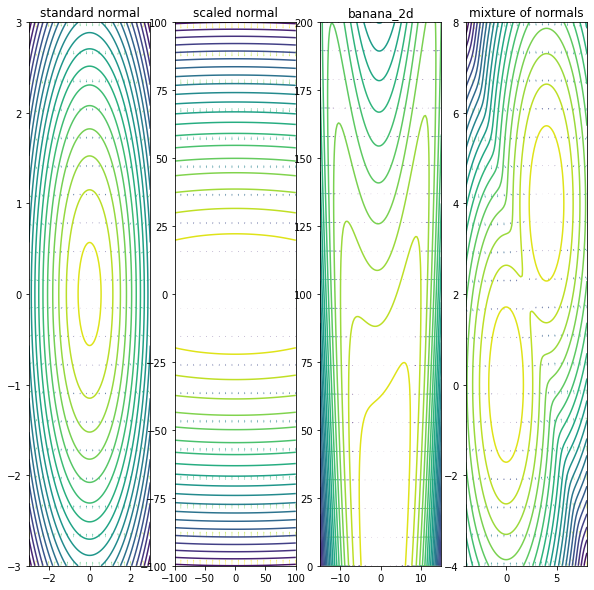

In [163]:
standard_normal = Normal(loc = 0., scale = 1.)
scaled_normal = Normal(loc = 0. , scale = torch.tensor([10.,1.]))
banana_2d = Rosenbrock_2d( torch.tensor(0.05), torch.tensor(5.),torch.tensor(1.) )
mixture = MixtureOfNormals(
    locs=[torch.tensor([0., 0.]), torch.tensor([4., 4.])], 
    scales=[1., 1.],
    pi=torch.tensor([0.5, 0.5])
)

fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(10, 10))
plot_distribution(standard_normal, bounds=((-3, 3), (-3, 3)), ax=axes[0], num=100, n_levels=20)
plot_distribution_grad(standard_normal, bounds=((-3, 3), (-3, 3)), ax=axes[0], num=20)
axes[0].set_title('standard normal')

plot_distribution(scaled_normal, bounds=((-100, 100), (-100, 100)), ax=axes[1], num=100, n_levels=20)
plot_distribution_grad(scaled_normal, bounds=((-100, 100), (-100, 100)), ax=axes[1], num=20)
axes[1].set_title('scaled normal')
 
plot_distribution(banana_2d, bounds=((-15, 15), (0, 200)),  ax=axes[2], num=100, n_levels=20)
plot_distribution_grad(banana_2d,  bounds=((-15, 15), (0, 200)), ax=axes[2], num=20)
axes[2].set_title('banana_2d');

plot_distribution(mixture, bounds=((-4, 8), (-4, 8)), ax=axes[3], num=100, n_levels=20)
plot_distribution_grad(mixture, bounds=((-4, 8), (-4, 8)), ax=axes[3], num=20)
axes[3].set_title('mixture of normals');

####  2. Proposals

- 1. Hamiltonian Monte Carlo
$$ H(\theta, r) = -\log \pi(\theta) + \frac{1}{2}r^{T}r $$
$$ r \sim \mathcal{N}(0,I) $$
$$ $$
$$ \theta^{'},r^{'} = integrate(\theta, r) $$
$$ $$
$$ $$
$$ \frac{\partial{\theta}}{\partial{t}} = \frac{\partial{H}}{\partial{r}}, \frac{\partial{r}}{\partial{t}} = - \frac{\partial{H}}{\partial{\theta}}$$
- 2. Random Walk Metropolis
$$ q(\theta^{'}|\theta) = \mathcal{N}(\theta^{'}|\theta, \sigma^{2}I)$$



In [150]:
class Proposal:
    
    def sample(self, x):
        """
        
        """
        
        raise NotImplementedError
        
    def log_density(self, x , x_prime):
        """
        
        """
        raise NotImplementedError
        
     

### Task 2 (30 points)

Fill functions such as sample and log_density for Randow Walk Metropolis usual proposal

In [152]:
class RandomWalk(Proposal):
    
    def __init__(self,sigma):
        """
        
        """
        super().__init__()
        self.sigma = sigma
        
        self.d = torch.distributions.Normal(loc = torch.tensor(0.), scale = sigma)
        
    def sample(self,x):
        """
        
        """
        s = self.d.sample(sample_shape=x.shape)
        return x + s
        
    def log_density(self,x,x_prime):
        """
        
        """
        return self.d.log_prob(x_prime - x).sum(dim=-1)

In [153]:
class HMC(Proposal):
    
    """
    
    Hamiltonian Monte Carlo
      
    """
    
    def __init__(self, eps, dist, n_steps = 5,  method ="leapfrog" ):
        
        """
        
        n_steps : steps of Hamiltonian Dynamics
        method : method of integrate new variables
        eps : error of discretization scheme
        dist : distribution unnormalized from which we want to sample
        d : distribution of auxiliary variables
        
        """
        self.n_steps = n_steps
        self.method = method
        self.eps = eps
        self._method = {"leapfrog":              self._leapfrog,
                        "euler"  :               self._euler,
                        "simple_euler_leapfrog": self._simple_euler}[method]
        
        
        self.d = torch.distributions.Normal(loc =0.,scale=1.)
        self.dist = dist
        
        
    def _energy(self,x,v):
        
        """
        Calculation of energy
        
        """
        
        return - self.dist.log_density(x) + self.d.log_prob(v).sum(dim = -1)
    
    
    def _leapfrog(self, x, v):
        
        """
        
        LeapFrog Integrate method
        
        """
        self.energy = []
        for _ in range(self.n_steps):
            
            v -= 0.5 * self.eps * self.dist.grad_log_density(x)
            x = x + self.eps * v
            v -= 0.5 * self.eps * self.dist.grad_log_density(x)
            self.energy.append(self._energy(x, v))
            
        return x, v
    
            
            
    def _euler(self, x , v):
        
        """
        Usual Integrate Euler method
        
        """
        self.energy = []
        for _ in range(self.n_steps):
            
            v -= self.eps * self.dist.grad_log_density(x)
            x = x + self.eps * v
            self.energy.append(self._energy(x,v))
            
        return x, v
            
    
    def _simple_euler(self, x, v):
        
        """
        Sample integrate Euler method
        
        """
        self.energy = []
        for _ in range(self.n_steps):
            
            x = x + self.eps*v
            v = v - self.eps * self.dist.grad_log_density(x)
            self.energy.append(self._energy(x,v))
            
        return x,v
    
        
    def sample(self, x):
        
        v = self.d.sample(sample_shape=x.shape)
        
        self.v0 = v.clone()
        self.x0 = x.clone()
        
        x,v = self._method(x,v)
        
        self.v = v
        
        return x

    
    def log_density(self, x, x_prime):
        
        if torch.norm(x - self.x0).item() < 1e-5:
            return self.d.log_prob(self.v0).sum(dim=-1)
        else:
            return self.d.log_prob(self.v).sum(dim=-1)
    
    def __str__(self):
        return f"HMC eps={self.eps}, n_steps={self.n_steps}, method={self.method}" 

### 3 MCMC

Create MCMC chain with distributions and proposals

### Task 3 ( 30 points )

Define function acceptance_prob and write your code

In [154]:
def plot_points(xs, ax, i=0, j=1, color=True):
    ax.set_title('points')
    ax.set_xlabel(f'coordinate {i}')
    ax.set_ylabel(f'coordinate {j}')
    
    n_parallel, n_samples, _ = xs.shape
    c = np.arange(n_samples) if color else None
    for k in range(n_parallel):
        ax.scatter(xs[k, :, i], xs[k, :, j], s=5, c=c)
    return ax

def plot_log_density(xs, ax, distribution):
    ax.set_title('log_density')
    ax.set_xlabel('iteration')
    ax.set_ylabel('log density')
    
    n_parallel, n_samples, _ = xs.shape
    for k in range(n_parallel):
        density = distribution.log_density(torch.tensor(xs[k]))
        ax.plot(density.numpy(), label=f'run {k + 1}')
    ax.legend(loc='best')
    return ax

In [155]:
class MCMC:
    def __init__(self, distribution, proposal):
        """
            Constructs MCMC sampler
        
            distribution (Distribution): distribution from which we sample
            proposal (Proposal): MCMC proposal
        """
        self.distribution = distribution
        self.proposal = proposal
    
    
    def _step(self, x):
        x_prime = self.proposal.sample(x)
        acceptance_prob = self.acceptance_prob(x_prime, x)
        
        mask = torch.rand(x.shape[0]) < acceptance_prob
        x[mask] = x_prime[mask]
        self._rejected += np.logical_not( mask).type(torch.float32)
        return x

    
    def simulate(self, initial_point, n_steps, n_parallel=10):
        """
            Run `n_parallel ` simulations for `n_steps` starting from `initial_point`
            
            initial_point (torch tensor of shape D): starting point for all chains
            n_steps (int): number of samples in Markov chain
            n_parallel (int): number of parallel chains
            returns: dict(
                points (torch tensor of shape n_parallel x n_steps x D): samples
                n_rejected (numpy array of shape n_parallel): number of rejections for each chain
                rejection_rate (float): mean rejection rate over all chains
                means (torch tensor of shape n_parallel x n_steps x D): means[c, s] = mean(points[c, :s])
                variances (torch tensor of shape n_parallel x n_steps x D): variances[c, s, d] = variance(points[c, :s, d])
            )
        """
        
        xs = []
        x = initial_point.repeat(n_parallel, 1)
         
        
        self._rejected = torch.zeros(n_parallel)
        
        
        dim = initial_point.shape[0]
        sums = np.zeros([n_parallel, dim])
        squares_sum = np.zeros([n_parallel, dim])
        
        means = []
        variances = []        
        
        
        for i in range(n_steps):
            
            x = self._step(x)
             
            xs.append(x.numpy().copy())
            
            sums += xs[-1]
            squares_sum += xs[-1]**2
            
            mean, squares_mean = sums / (i + 1), squares_sum / (i + 1)
            means.append(mean.copy())
            variances.append(squares_mean - mean**2)
        
        xs = np.stack(xs, axis=1)        
        means = np.stack(means, axis=1)
        variances = np.stack(variances, axis=1)
        
        return dict(
            points=xs,
            n_rejected=self._rejected.numpy(),
            rejection_rate=(self._rejected / n_steps).mean().item(),
            means=means,
            variances=variances
        )
        
    def acceptance_prob(self, x_prime, x):
        """
            In this function you need to compute 
            probability of acceptance \rho(x' | x)

            x_prime (numpy array): new point
            x (numpy array): current point
            returns: acceptance probability \rho(x', x)
        """
        pi_prime = self.distribution.log_density(x_prime)
        pi = self.distribution.log_density(x)
        q_prime = self.proposal.log_density(x_prime, x)
        q = self.proposal.log_density(x, x_prime)
        return torch.exp(pi_prime - pi + q_prime - q).clamp(0., 1.)
    
def simulate(distribution, proposal, initial_point, n_samples, n_parallel=10):
    mcmc = MCMC(distribution, proposal)
    return mcmc.simulate(initial_point, n_samples, n_parallel)

In [156]:
def simulate(distribution, proposal , initial_point, n_samples, n_parallel = 10):
    mcmc = MCMC(distribution, proposal)
    return mcmc.simulate(initial_point,n_samples, n_parallel)

In [157]:
def tuning_experiment(distribution, proposal, hyperparameters, options, color=True):
    fig, axes = plt.subplots(ncols=len(hyperparameters), figsize=(20, 20))

    for i, hp in enumerate(hyperparameters):
        result = simulate(distribution, proposal(**hp), **options)
        ax = axes[i]
        plot_points(result['points'], ax, color=color)
        
        ax.set_aspect('equal')
        hp_string = ', '.join(f'{k}={v}' for k, v in hp.items())
        ax.set_title(f'{hp_string}, rejection rate = {result["rejection_rate"]:.2f}')
        ax.set_xlim(-4., 4.)
        ax.set_ylim(-4., 4.)

### 4.  Perform the Experiment

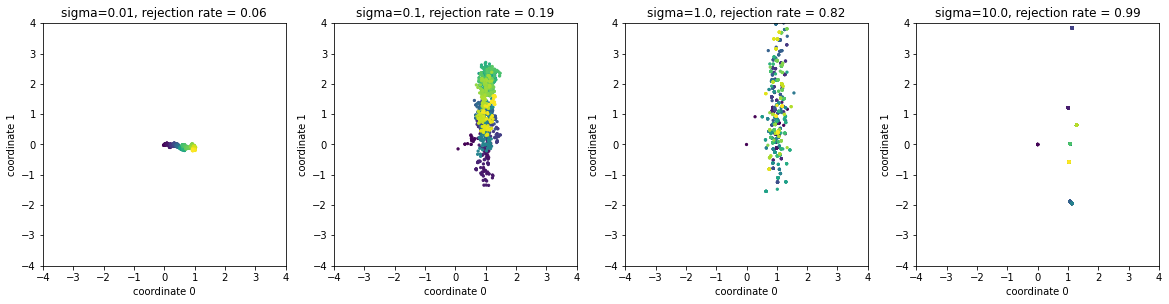

In [164]:
sigmas = [0.01, 0.1, 1.0, 10.]

tuning_experiment(
    banana_2d,
    proposal=RandomWalk,
    hyperparameters=[dict(sigma=s) for s in sigmas],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=1000,
        n_parallel=1
    )
)

### Task 4 (10 points)

Describe how does sampling method change its result

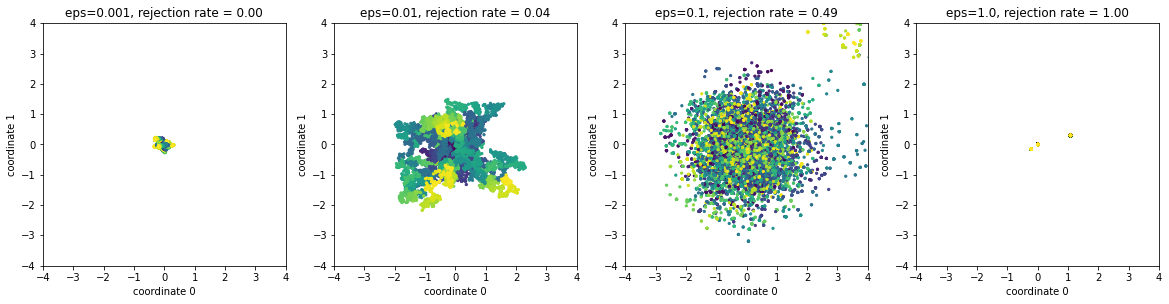

In [165]:
# choose some step sizes and run simulation
step_sizes = sigmas = [0.001, 0.01, 0.1, 1.]

proposal = lambda eps: HMC( eps ,dist=standard_normal)

tuning_experiment(
    mixture,
    proposal=proposal,
    hyperparameters=[dict(eps=e) for e in step_sizes],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=1000,
        n_parallel=10
    )
)

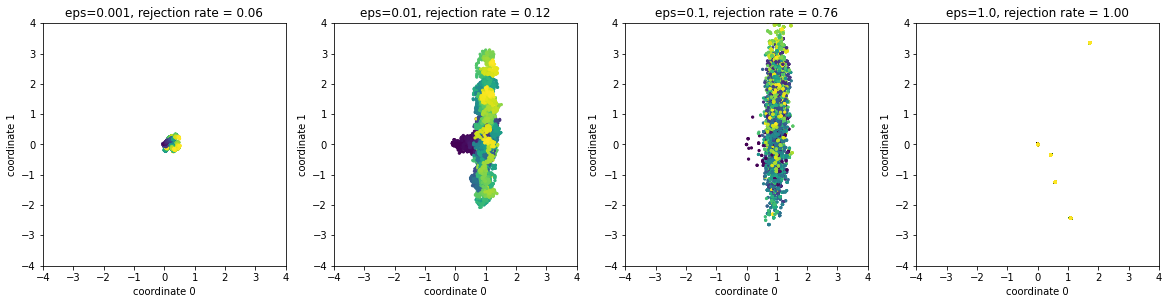

In [166]:
# choose some step sizes and run simulation
step_sizes = sigmas = [0.001, 0.01, 0.1, 1.]

proposal = lambda eps: HMC( eps ,dist=standard_normal)

tuning_experiment(
    banana_2d,
    proposal=proposal,
    hyperparameters=[dict(eps=e) for e in step_sizes],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=1000,
        n_parallel=10
    )
)

The sampling method affects the form.